In [1]:
# *****************************************************
# * Import required packages and set up path for ODYM *
# *****************************************************

import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from core.dataprovider import DataProvider
from core.datachecker import DataChecker
from core.datavisualizer import DataVisualizer
from core.flowsolver import FlowSolver

# Path configuration
MainPath = os.path.join('.')
sys.path.insert(0, MainPath)
sys.path.insert(0, os.path.join(os.getcwd(), '.', 'lib', 'odym', 'modules'))

# ODYM classes
import ODYM_Classes as msc

# Detect if running inside Jupyter Notebook
%matplotlib inline

In [2]:
# ******************************************************
# * Step 1: Load the data from Excel file DataProvider *
# ******************************************************

# Load data from file using the DataProvider
# and get model parameters from the file
#filename = "data/example_data.xlsx"
filename = "data/20240910_data_dynamic.xlsx"

print("Loading data from file {}...".format(filename))
dataprovider = DataProvider(filename)

# Model parameters is a Dictionary that contains loaded data from Excel sheet named "Settings"
# and are used for running the FlowSolver and setting up ODYM
model_params = dataprovider.get_model_params()
print("Using following parameters for running the model:")
for param_name, param_value in model_params.items():
    print("\t{:32}= {}".format(param_name, param_value))

Loading data from file data/20240910_data_dynamic.xlsx...
Using following parameters for running the model:
	sheet_name_processes            = Processes
	column_range_processes          = B:R
	skip_num_rows_processes         = 2
	sheet_name_flows                = Flows
	column_range_flows              = B:U
	skip_num_rows_flows             = 2
	start_year                      = 2021
	end_year                        = 2030
	detect_year_range               = True
	use_virtual_flows               = False
	virtual_flows_epsilon           = 0.1
	conversion_factor_c_to_co2      = 3.67


In [3]:
# **************************************************************
# * Step 2: Check data integrity and build data for FlowSolver *
# **************************************************************

print("Checking errors in data...")
datachecker = DataChecker(dataprovider)
flowsolver_data = datachecker.build_flowsolver_data()
is_checker_ok, checker_messages = datachecker.check_for_errors()
if not is_checker_ok:
    for msg in checker_messages:
        print(msg)
    SystemExit(-1)

# Get the updated years from graph_data
# If using parameter "detect_year_range" DataChecker will automatically adjust
# the starting and ending years and update the used years
years = flowsolver_data["years"]
print("Using year range {} - {}".format(min(years), max(years)))

Checking errors in data...
Checking stock distribution types...
Checking stock distribution parameters...
Checking process total inflows and total outflows mismatches...
Total inflows and total outflows for process 'Industrial_roundwood:EU' does not match.
Absolute difference of total inflows and total outflows was 109.63805853576235
Check following inflows in Excel sheet 'Flows':
- flow 'Industrial_roundwood:Import Industrial_roundwood:EU' in row 178
- flow 'Roundwood:EU Industrial_roundwood:EU' in row 239
Check following outflows:
- flow 'Industrial_roundwood:EU Sawnmill:EU' in row 483
- flow 'Industrial_roundwood:EU Wood_panel:EU' in row 544
- flow 'Industrial_roundwood:EU Pulp_and_wood_pulp:EU' in row 666
- flow 'Industrial_roundwood:EU Industrial_roundwood:Export' in row 1822

Total inflows and total outflows for process 'Industrial_roundwood:EU' does not match.
Absolute difference of total inflows and total outflows was 111.3061556578089
Check following inflows in Excel sheet 'Fl

In [5]:
# *******************************************************************
# * Step 3: Solve flows for all timesteps using aiphoria FlowSolver *
# *******************************************************************

print("Solving mass flows for every timestep...")
flowsolver = FlowSolver(data=flowsolver_data)
flowsolver.solve_timesteps()

Solving mass flows for every timestep...
Solving flows for years 1900 - 2022...
Using virtual flows = False


Solving flows: 100%|██████████| 2023/2023 [00:00<00:00, 338.33it/s]


In [6]:
# ******************************************************
# * Step 4: Setup ODYM classifications and index table *
# ******************************************************

# Get model time start, end, and duration:
model_time_start = int(min(years))
model_time_end = int(max(years))
model_duration = model_time_end - model_time_start
model_elements = ['Solid wood equivalent', 'Carbon']
model_years = years

# Track solid wood equivalent and carbon. Dictionary of classifications enters the index table defined for the system. The index table lists all aspects needed and assigns a classification and index letter to each aspect.
model_classifications = {
    'Time': msc.Classification(Name='Time', Dimension='Time', ID=1, Items=model_years),
    'Cohort': msc.Classification(Name='Age-cohort', Dimension='Time', ID=2, Items=model_years),
    'Element': msc.Classification(Name='Elements', Dimension='Element', ID=3, Items=model_elements),
}

index_table = pd.DataFrame({'Aspect': ['Time', 'Age-cohort', 'Element'],  # 'Time' and 'Element' must be present!
                            'Description': ['Model aspect "time"', 'Model aspect "age-cohort"', 'Model aspect "Element"'],
                            'Dimension': ['Time', 'Time', 'Element'],  # 'Time' and 'Element' are also dimensions
                            'Classification': [model_classifications[Aspect] for Aspect in ['Time', 'Cohort', 'Element']],
                            'IndexLetter': ['t', 'c', 'e' ]})  # Unique one letter (upper or lower case) indices to be used later for calculations.

index_table.set_index('Aspect', inplace=True)  # Default indexing of IndexTable, other indices are produced on the fly
index_table


,Description,Dimension,Classification,IndexLetter
Aspect,,,,
Time,"Model aspect ""time""",Time,<ODYM_Classes.Classification object at 0x00000...,t
Age-cohort,"Model aspect ""age-cohort""",Time,<ODYM_Classes.Classification object at 0x00000...,c
Element,"Model aspect ""Element""",Element,<ODYM_Classes.Classification object at 0x00000...,e


In [7]:
# **************************************
# * Step 5: Initialize ODYM MFA system *
# **************************************

mfa_system = msc.MFAsystem(Name='Wood product system', Geogr_Scope='Europe', Unit='Mm3',
                           ProcessList=[], FlowDict={}, StockDict={}, ParameterDict={},
                           Time_Start=model_time_start, Time_End=model_time_end, IndexTable=index_table,
                           Elements=index_table.loc['Element'].Classification.Items)

# Get inflow values to stock
year_index_to_year = dict(enumerate(years))
unique_processes = flowsolver.get_unique_processes()
unique_flows = flowsolver.get_unique_flows()

# DataFrames for Processes, Flows and Flow values
print("Collecting processes to DataFrame...")
df_processes = flowsolver.get_processes_as_dataframe()
print("Collecting flows to DataFrame...")
df_flows = flowsolver.get_flows_as_dataframe()
print("Collecting evaluated flow values to DataFrame...")
df_flow_values = flowsolver.get_evaluated_flow_values_as_dataframe()

print("Creating ODYM objects...")
# Create ODYM objects
odym_processes = []
process_id_to_index = {}
for process_id, process in unique_processes.items():
    process_index = len(odym_processes)
    process_id_to_index[process_id] = process_index
    new_process = msc.Process(ID=process_index, Name=process.name)
    odym_processes.append(new_process)

odym_flows = {}
for flow_id, flow in unique_flows.items():
    source_process_index = process_id_to_index[flow.source_process_id]
    target_process_index = process_id_to_index[flow.target_process_id]
    new_flow = msc.Flow(ID=flow.id, P_Start=source_process_index, P_End=target_process_index, Indices='t,e', Values=None)
    odym_flows[flow.id] = new_flow

odym_stocks = {}
for stock in flowsolver.get_all_stocks():
    process_index = process_id_to_index[stock.id]
    new_stock = msc.Stock(ID=stock.id, Name=stock.name, P_Res=process_index, Indices='t,e', Type=0, Values=None)
    odym_stocks[stock.id] = new_stock

mfa_system.ProcessList = odym_processes
mfa_system.FlowDict = odym_flows
mfa_system.StockDict = odym_stocks
mfa_system.Initialize_FlowValues()
mfa_system.Initialize_StockValues()
mfa_system.Consistency_Check()

# Update ODYM flow values from flow values DataFrame
for flow_id, flow in mfa_system.FlowDict.items():
    for year_index, value in enumerate(flow.Values):
        # NOTE: Virtual flows use default value defined in Flow for carbon content (now 1.0).
        solved_flow = flowsolver.get_flow(year=year_index_to_year[year_index], flow_id=flow_id)
        flow.Values[year_index, 0] = solved_flow.evaluated_value
        flow.Values[year_index, 1] = solved_flow.evaluated_value_carbon

# Process stocks (fill with data)
for stock_id, stock in odym_stocks.items():
    # Calculate cohorts for "Solid wood equivalent"
    dsm_swe = flowsolver.get_dynamic_stocks_swe()[stock_id]
    swe_stock_by_cohort = dsm_swe.compute_s_c_inflow_driven()
    swe_outflow_by_cohort = dsm_swe.compute_o_c_from_s_c()
    swe_stock_total = dsm_swe.compute_stock_total()
    swe_stock_change = dsm_swe.compute_stock_change()
    stock.Values[:, 0] = swe_stock_change

    # Calculate cohorts for "Carbon"
    dsm_carbon = flowsolver.get_dynamic_stocks_carbon()[stock_id]
    carbon_stock_by_cohort = dsm_carbon.compute_s_c_inflow_driven()
    carbon_outflow_by_cohort = dsm_carbon.compute_o_c_from_s_c()
    carbon_stock_total = dsm_carbon.compute_stock_total()
    carbon_stock_change = dsm_carbon.compute_stock_change()
    stock.Values[:, 1] = carbon_stock_change

print("Mass balance difference per year")
mb = mfa_system.MassBalance()
print("Mass balance result shape: {}".format(mb.shape))
df_mass_balance = pd.DataFrame(columns=["Year", "Process 0", "Rest", "Abs difference"])
for year_index, year in enumerate(years):
    # Calculate mass balance using the first element in MFA system (= base element)
    # Negative value in process 0 means that process 0 has no inflows so this mass
    # is coming from outside system boundaries
    p0 = np.sum(mb[year_index][0][0])
    rest = np.sum(mb[year_index][1:,0])
    abs_diff = abs(p0) - abs(rest)
    df_mass_balance.loc[year_index] = np.array([year, p0, rest, abs_diff])
df_mass_balance = df_mass_balance.astype({"Year": "int32"})
df_mass_balance.set_index(["Year"], inplace=True)
print(df_mass_balance)

Creating ODYM objects...
Mass balance difference per year
Mass balance result shape: (123, 63, 2)
       Process 0        Rest  Abs difference
Year                                        
1900 -213.889555  213.889555    2.842171e-14
1901 -217.143795  217.143795    0.000000e+00
1902 -220.447546  220.447546    2.842171e-14
1903 -223.801564  223.801564   -2.842171e-14
1904 -227.206611  227.206611    0.000000e+00
...          ...         ...             ...
2018 -883.223098  883.223098   -1.136868e-13
2019 -890.375796  890.375796   -1.136868e-13
2020 -862.682989  862.682989   -1.136868e-13
2021 -953.525378  953.525378    3.410605e-13
2022 -887.593133  887.593133    1.136868e-13

[123 rows x 3 columns]


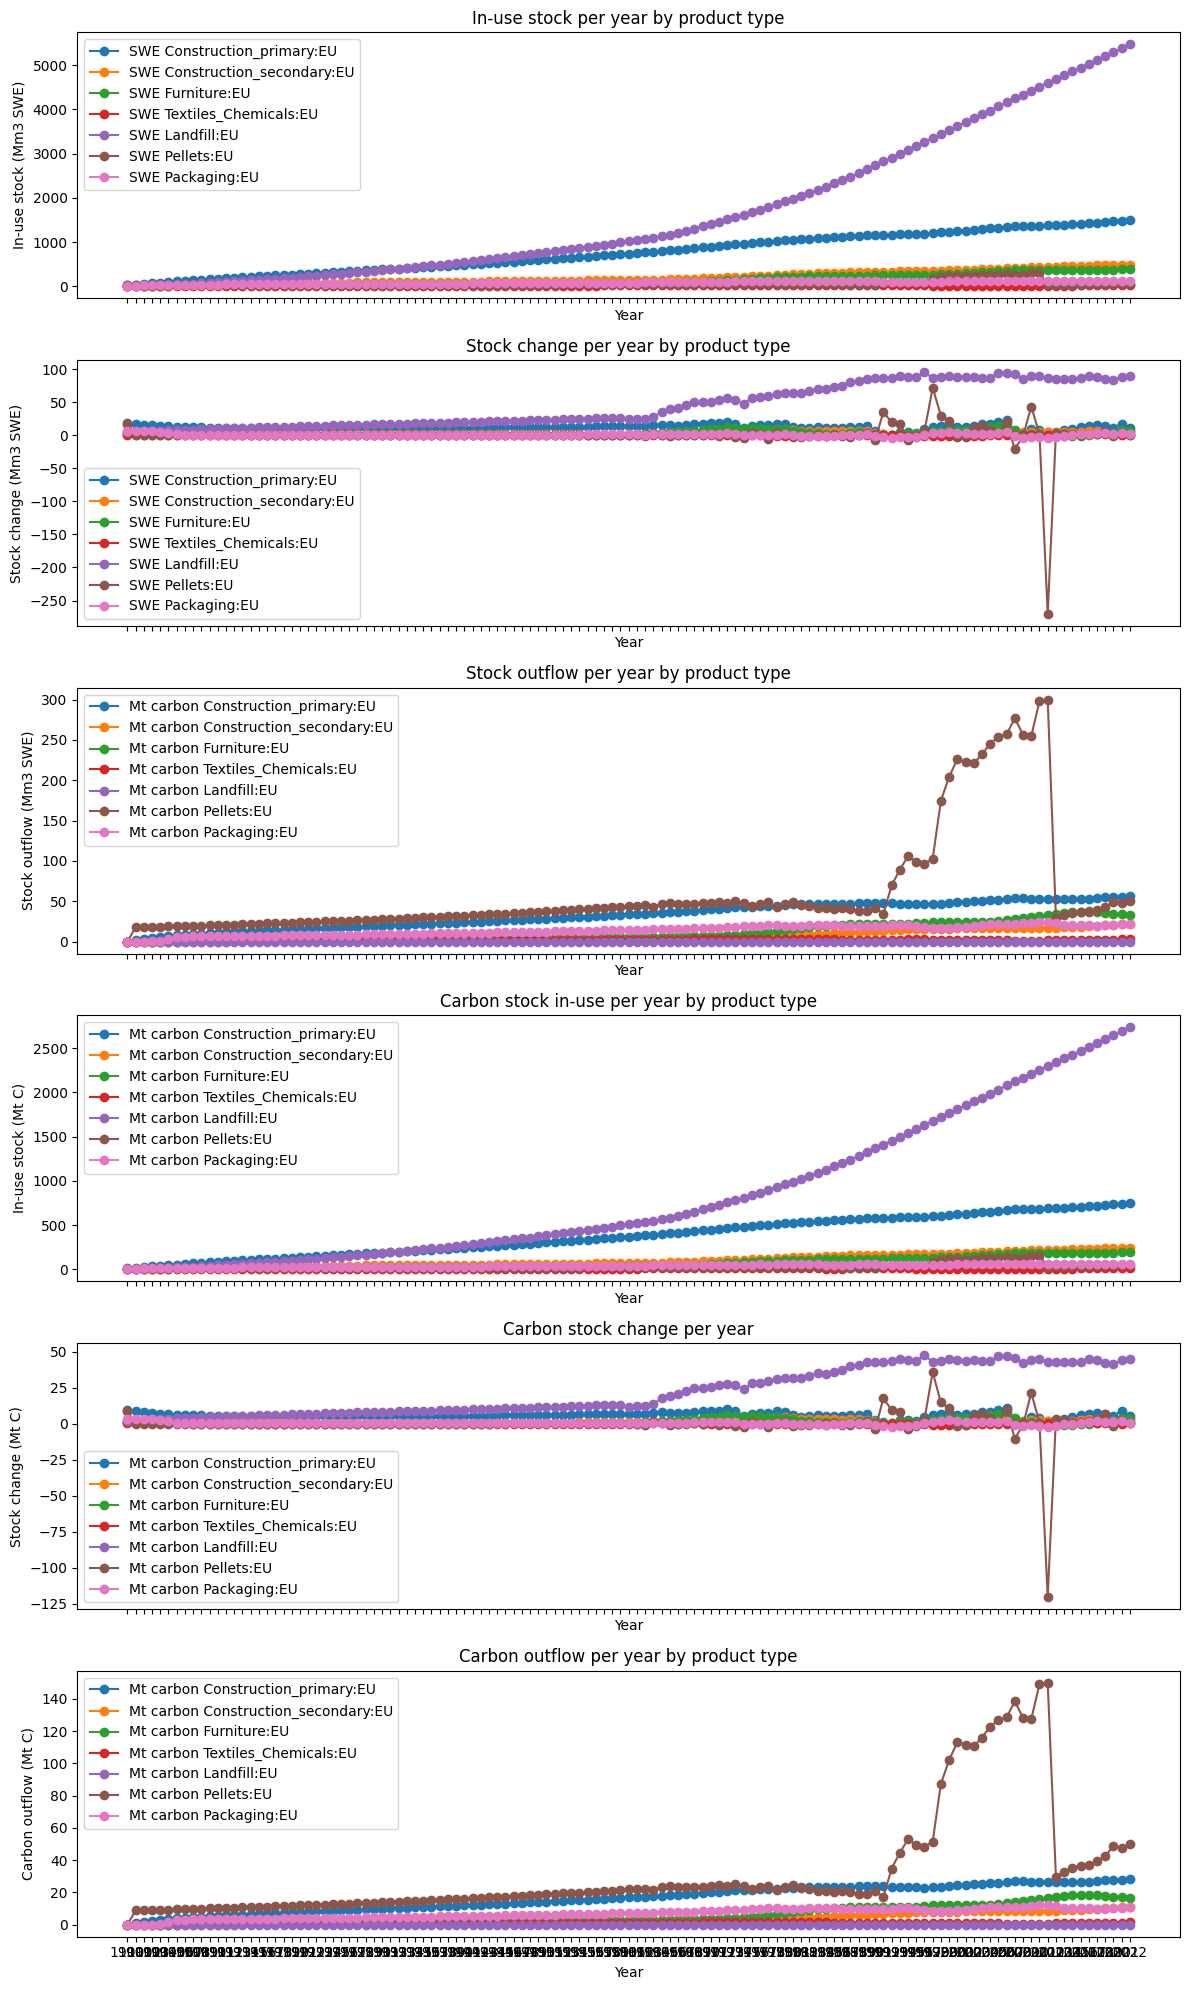

In [8]:
# *****************************************************
# * Step 6: Plot the dynamic stocks results *
# *****************************************************
fig, axes = plt.subplots(6, 1, sharex='all', sharey='none', figsize=(12, 20))

# stock_id_to_dsm_swe and stock_id_to_dsm_carbon are dictionaries containing DynamicStockModel instances
stock_id_to_dsm_swe = flowsolver.get_dynamic_stocks_swe()
stock_id_to_dsm_carbon = flowsolver.get_dynamic_stocks_carbon()
for stock_id in stock_id_to_dsm_swe.keys():
    # SWE Stock
    dsm_swe = stock_id_to_dsm_swe[stock_id]
    swe_stock_by_cohort = dsm_swe.compute_s_c_inflow_driven()
    swe_oc = dsm_swe.compute_o_c_from_s_c()
    swe_stock_total = dsm_swe.compute_stock_total()
    swe_stock_change = dsm_swe.compute_stock_change()
    swe_o = dsm_swe.compute_outflow_total()

    # Carbon stock
    dsm_carbon = stock_id_to_dsm_carbon[stock_id]
    carbon_stock_by_cohort = dsm_carbon.compute_s_c_inflow_driven()
    carbon_oc = dsm_carbon.compute_o_c_from_s_c()
    carbon_stock_total = dsm_carbon.compute_stock_total()
    carbon_stock_change = dsm_carbon.compute_stock_change()
    carbon_o = dsm_carbon.compute_outflow_total()

    # Plot SWE stock total (in-use stocks)
    axes[0].plot(years, swe_stock_total, marker='o', label=f'SWE {stock_id}')
    axes[0].set_ylabel("In-use stock (Mm3 SWE)")
    axes[0].set_title("In-use stock per year by product type")

    # Plot SWE stock change
    axes[1].plot(years, swe_stock_change, marker='o', label=f'SWE {stock_id}')
    axes[1].set_ylabel("Stock change (Mm3 SWE)")
    axes[1].set_title("Stock change per year by product type")

    # Plot SWE outflow by cohort
    axes[2].plot(years, swe_o, marker='o', label=f'Mt carbon {stock_id}')
    axes[2].set_ylabel("Stock outflow (Mm3 SWE)")
    axes[2].set_title("Stock outflow per year by product type")

    # Plot Carbon stock total (in-use stocks)
    axes[3].plot(years, carbon_stock_total, marker='o', label=f'Mt carbon {stock_id}')
    axes[3].set_ylabel("In-use stock (Mt C)")
    axes[3].set_title("Carbon stock in-use per year by product type")

    # Plot Carbon stock change
    axes[4].plot(years, carbon_stock_change, marker='o', label=f'Mt carbon {stock_id}')
    axes[4].set_ylabel("Stock change (Mt C)")
    axes[4].set_title("Carbon stock change per year")

    # Plot carbon outflow by cohort
    axes[5].plot(years, carbon_o, marker='o', label=f'Mt carbon {stock_id}')
    axes[5].set_ylabel("Carbon outflow (Mt C)")
    axes[5].set_title("Carbon outflow per year by product type")

# Set common properties to axes
range_x_ticks = range(min(years), max(years) + 1)
for axis in axes:
    axis.set_xlabel("Year")
    axis.set_xticks(range_x_ticks)
    axis.title.set_size(12)
    axis.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as an SVG file
svg_file_path = "data/stock_plots_by_product.svg"
plt.savefig(svg_file_path, format='svg')

plt.show()

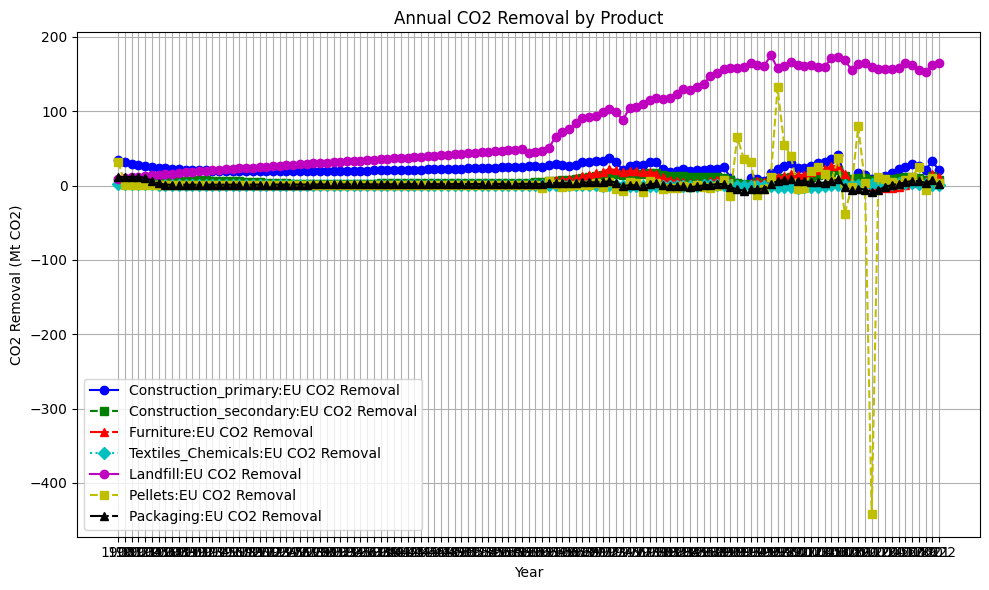

     Year  Construction_primary:EU CO2 Removal (Mt)  \
0    1900                                 34.833098   
1    1901                                 31.776203   
2    1902                                 29.255477   
3    1903                                 27.379103   
4    1904                                 25.921245   
..    ...                                       ...   
118  2018                                 28.545559   
119  2019                                 25.915915   
120  2020                                 21.283571   
121  2021                                 32.463743   
122  2022                                 20.740939   

     Construction_secondary:EU CO2 Removal (Mt)  \
0                                      5.790762   
1                                      5.878862   
2                                      5.968293   
3                                      6.059056   
4                                      6.151120   
..                               

In [9]:
# *****************************************************
# * Step 7: Convert the carbon stocks to CO2 removals *
# *****************************************************
year_start = min(flowsolver_data["years"])
years = flowsolver_data["years"]

# Calculate annual CO2 removal for each stock
results_co2_removals = pd.DataFrame({'Year': years})
stock_id_to_dsm_carbon = flowsolver.get_dynamic_stocks_carbon()
for stock_id, dsm_carbon in stock_id_to_dsm_carbon.items():
    total_inflows_carbon = dsm_carbon.i
    total_outflows_carbon = dsm_carbon.o
    annual_co2_removal = (total_inflows_carbon - total_outflows_carbon) * model_params["conversion_factor_c_to_co2"]
    results_co2_removals[f'{stock_id} CO2 Removal (Mt)'] = annual_co2_removal

# Plot each product's CO2 removal
plt.figure(figsize=(10, 6))

# Define line styles, markers, and colors for differentiation
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for idx, stock_id in enumerate(stock_id_to_dsm_carbon.keys()):
    line_style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    color = colors[idx % len(colors)]

    if f'{stock_id} CO2 Removal (Mt)' in results_co2_removals.columns:
        plt.plot(results_co2_removals['Year'], results_co2_removals[f'{stock_id} CO2 Removal (Mt)'], marker=marker, linestyle=line_style, color=color, label=f'{stock_id} CO2 Removal')

plt.xlabel('Year')
plt.ylabel('CO2 Removal (Mt CO2)')
plt.title('Annual CO2 Removal by Product')
plt.grid(True)
plt.xticks(years)
plt.legend()
plt.tight_layout()

# Save the figure as an SVG file
svg_file_path = "data/annual_co2_removal_by_product.svg"
plt.savefig(svg_file_path, format='svg')

plt.show()
print(results_co2_removals)

In [10]:
# ************************************************************
# * Step 8: Visualize inflows per year to selected processes *
# ************************************************************

# Visualize inflows per year to processes
process_ids_to_visualize = ["Incineration:FI", "Sawmilling:FI"]
for process_id in process_ids_to_visualize:
    flow_id_to_source_process_id = {}
    source_process_names = []

    # Find all source processes of all incoming flows to this process in all years
    # This is needed to create stable set of process names so that the relative
    # position of the processes stay the same in stacked chart between the years
    source_process_ids = set()
    for year in years:
        inflows = flowsolver.get_process_flows(process_id, year)["Inflows"]
        unique_flow_ids = set()
        for flow in inflows:
            unique_flow_ids.add(flow.id)
            flow_id_to_source_process_id[flow.id] = flow.source_process_id

        # Find source process ID of each incoming flow and add
        # to list of unique source process IDs if not already there
        unique_flow_ids = list(unique_flow_ids)
        for flow_id in unique_flow_ids:
            source_process_ids.add(flow_id_to_source_process_id[flow_id])

    # Now source_process_ids-list contains list of all the possible process IDs
    # that have flows incoming to process_id. This list is needed to keep the
    # incoming process IDs the same every year because aiphoria allows the connections
    # between the flows to change between the years.
    source_process_ids = list(source_process_ids)

    # Create 2D array with shape of (number of source process IDs, number of years)
    # and fill with the value of the inflow from source process for each year
    source_process_by_flow_values = np.ndarray(shape=(len(source_process_ids), len(years)))
    for year_index, year in enumerate(years):
        inflows = flowsolver.get_process_flows(process_id, year)["Inflows"]
        for flow in inflows:
            source_process_id_index = source_process_ids.index(flow.source_process_id)
            source_process_by_flow_values[source_process_id_index, year_index] = flow.evaluated_value

    # Get the process name for the currently visualized process
    process = flowsolver.get_process(process_id, min(years))

    # Initialize the figure and axes for the stacked area chart
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.stackplot(years, source_process_by_flow_values, labels=list(source_process_ids))
    ax.set_ylabel("Mm3 SWE")
    ax.set_title("Inflows to {}".format(process.name))
    ax.legend(loc='upper left')
    plt.xticks(years)

    # Save the figure as an SVG file
    svg_file_path = "data/inflows_to_processes_{}.svg".format(process.name)
    plt.savefig(svg_file_path, format='svg')
    plt.show()

KeyError: 'Incineration:FI'

In [12]:
# *****************************************************
# * Step 9: Visualize the flow graph as Sankey graph *
# *****************************************************

# Color mappings
process_transformation_stage_colors = dict()
process_transformation_stage_colors["Source"] = "#7DDA60"
process_transformation_stage_colors["First"] = "#eb5e34"
process_transformation_stage_colors["Second"] = "#8c76cf"
process_transformation_stage_colors["Third"] = "#5BAA11"
process_transformation_stage_colors["VAM"] = "#3281db"
process_transformation_stage_colors["RoW"] = "#61b053"  # Rest of the world
process_transformation_stage_colors["EoL"] = "#EFC3CA"  # Brown
process_transformation_stage_colors["by_prod"] = "#DFC57B"  # gold
process_transformation_stage_colors["Virtual"] = "#707070"
process_transformation_stage_colors["Other"] = "#707070"


# Label overrides
virtual_process_graph_labels = dict()
virtual_process_graph_labels["VP_P2:EU"] = "Unreported flow from P2"
virtual_process_graph_labels["VP_P3:EU"] = "Unreported flow from P3"

# Virtual Process and virtual Flow colors
visualizer_params = {
    # User can hide processes in Sankey graph that have total inflows less than this value
    # This value cannot be changed now in the Sankey graph
    "small_node_threshold": 5,

    # Dictionary to define labels for virtual flows
    # If dictionary contains label for the virtual process then that is used,
    # otherwise the virtual process ID is used
    "virtual_process_graph_labels": virtual_process_graph_labels,

    # Dictionary to define color of process by the process transformation stage name
    # All must be provided as a RGB hex string, prefixed by character '#'
    # Usage example: { "Source": "#707070" }
    "process_transformation_stage_colors": process_transformation_stage_colors,

    # How transparent flows are (0.0 = invisible, 1.0 = fully opaque)
    "flow_alpha": 0.75,

    # Color for virtual process
    "virtual_process_color": "rgba(0.3, 0.3, 0.3, 0.6)",

    # Color for virtual flows
    "virtual_flow_color": "rgba(0.5, 0.5, 0.5, 0.5)",
}

visualizer = DataVisualizer()
visualizer.build(flowsolver, visualizer_params)
visualizer.show()